# Homework information


**Students:** Черкашина Елизавета Андреевна, Мешков Михаил Алексеевич

**Master’s programme:** Data Analytics and Social Statistics

**Task:**  Module 2. Hard skills project № 4 `Text analysis'

**Date:** 17.12.2024  

## Information about environment versions

- Python 3.12.7
- Pandas 2.2.3
- Matplotlib 3.9.2
- Spacy 3.8.3
- Scikit-learn  1.5.1
- Seaborn 0.13.2
- TextBlob 0.18.0


# Описание задачи (как сделаем можно убрать)

## Tasks
**To receive 70 / 100 points (basic questions):**
1. Load "text" and "target" columns to pandas dataframe. Pick random 1000 lines from the dataframe. Compute average text length, and dictionary size.
2. Find POSITIVE and NEGATIVE texts using flair or spacy. Add sentiment classification result to the dataframe. Supply this section with sentiment label distribution chart and discussion.
3. Compare spacy (or flair) results with the "target" column, build confusion matrix and discuss it.
4. Find all PERSONs and ORGANISATIONs in POSITIVE texts and add them to your dataframe. If there are multiple entities inside one text create separate lines for each entity.
5. Find the most frequent PERSON and ORGANISATION in positive texts.

**To receive additional 30 / 100 points (advanced questions):**

6. Cluster NEGATIVE texts using k-means clustering. Use tf-idf function to rank important phrases inside each document.
7. Describe each NEGATIVE cluster with a list of key phrases or summary.

## Submission format
You should submit your project as the python notebook (.ipynb) file and supplementary pdf file, generated from the python notebook. All questions of the Task section should be covered with code and markdown comments that are supposed to give a brief idea about what is happening in the code below and brief results discussion. Your report should be no longer than 5 pages including pictures.

* Each section (1-7) should be supported with introduction and conclusion/discussion markdown text to be considered done.
* The code cells should be executed and do not contain compilation and logical mistakes, there should not be unnecessary code and unused libraries inside the notebook.

## Tips and tricks

You can use materials from practical sections of Module 5 “Contemporary Text Analysis”.
In addition to that, below you can find the function to create a confusion matrix given the predicted and target columns in dataframe:
``` python
import pandas as pd
def confusion_matrix(df: pd.DataFrame, col1: str, col2: str): return (df
.groupby([col1, col2]) .size()
.unstack(fill_value=0)
) ```

# Code

## Import libraries

In [39]:
#import libraries
#import kagglehub
import pandas as pd
from matplotlib import pyplot as plt
import spacy
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from textblob import TextBlob
import warnings

# disable warnings 
warnings.filterwarnings("ignore")
# making ggplot style
plt.style.use('ggplot')

In [2]:
# download latest version dataset via API, for download uncomment

#path = kagglehub.dataset_download("kazanova/sentiment140")
#print("Path to dataset files:", path)

## Task №1

### 1.1 Load "text" and "target" columns to pandas. 

**Dataset description** from https://www.kaggle.com/datasets/kazanova/sentiment140/data

**Context**

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

**Content**

It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2. ids: The id of the tweet ( 2087)

3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.

5. user: the user that tweeted (robotickilldozr)

6. text: the text of the tweet (Lyx is cool)



In [2]:
# import data
data = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                 encoding='latin-1', 
                 names = ["target", "ids", "date", "flag", "user", "text"])

In [4]:
# checking informathion about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [3]:
# take a look at data
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Conclusion:**  data loaded correctly and contain and information same as at the description.


In [3]:
# filter the columns we'll be working with
data_filtered = data[["target", "text"]]
# filter the random 1000 rows and making final df for work
df = data_filtered.sample(n=1000, random_state=42425).reset_index(drop=True)
# take a look at final df
df

,target,text
0,4,Going to pic quick join?
1,0,urg. i should be somewhere I really want to b...
2,4,Help me!!! Chanting NO CAKE NO CAKE!! LOL BD ...
3,0,"@AritheGenius Awww, we still love you though EB"
4,4,trying to find my life again
...,...,...
995,0,my house has become a bar. i want to go to bed.
996,0,Very Stormy here. I don't like. This huge burs...
997,0,i miss mcfly...
998,4,@_speranza hehe I managed to swipe a wee day o...


**Conclusion:**  data frame for work have been made.

### 1.2 Compute average text length, and dictionary size. 

In [4]:
# load model
nlp = spacy.load("en_core_web_trf")

In [ ]:
# making anonymous function to find tokens
df['tokens'] = df['text'].apply(lambda x: [token.text.lower() 
                                           for token in nlp(x) 
                                           if token.is_alpha])

# calculate average text length
total_length = df['tokens'].apply(len).sum()
average_length = total_length / len(df)

# finding unique tokens
unique_tokens = set(token for tokens in df['tokens'] for token in tokens)
dictionary_size = len(unique_tokens)

In [9]:
print ("\033[1mConclusion:\033[0m")
print(f"Average text length: {average_length:.2f} tokens")
print(f"Dictionary size: {dictionary_size} tokens")

Conclusion:
Average text length: 11.97 tokens
Dictionary size: 2914 tokens


## Task №2

In this section we are conducting our sentiment analysis. We chose to use the 
textblob pretrained model and preprocessed the data with spacy. 
We use textblob to produce negative/positive sentiment classification, 
which correlates well with our "target" column for easier comparison later on. 
Compared to some tools for sentiment analysis from spacy or other packages, 
this model is usually more accurate and convenient to use.

<Axes: xlabel='target', ylabel='count'>

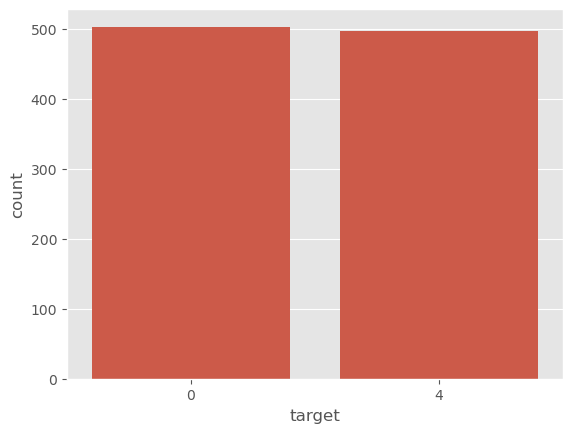

In [28]:
# target column values (sentiment) count 
sns.countplot(x='target', data=df)

As we can see from the graph, the dataset has no tweets with neutral (target=2)
sentiment. Thus, our model will be classifying tweets as positive and negative.

In [33]:
# spacy/textblob sentiment analysis

# sentiment classification function
def get_sentiment(tweet):
    # textblob for sentiment polarity
    blob = TextBlob(tweet)
    polarity = blob.sentiment.polarity  # polarity range is from -1 to 1 
    if polarity > 0:
        return "Positive"
    else:
        return "Negative"

# applying sentiment function
df["sentiment"] = df["text"].apply(get_sentiment)

# dataframe with results 
df

,target,text,sentiment,target_map
0,4,Going to pic quick join?,Positive,Positive
1,0,urg. i should be somewhere I really want to b...,Positive,Negative
2,4,Help me!!! Chanting NO CAKE NO CAKE!! LOL BD ...,Positive,Positive
3,0,"@AritheGenius Awww, we still love you though EB",Positive,Negative
4,4,trying to find my life again,Negative,Positive
...,...,...,...,...
995,0,my house has become a bar. i want to go to bed.,Negative,Negative
996,0,Very Stormy here. I don't like. This huge burs...,Positive,Negative
997,0,i miss mcfly...,Negative,Negative
998,4,@_speranza hehe I managed to swipe a wee day o...,Negative,Positive


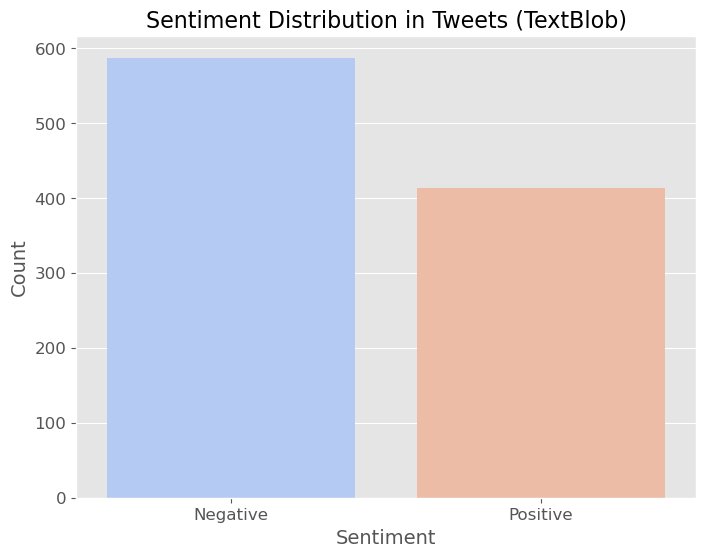

In [34]:
# sentiment distribution for TextBlob results
# number of tweets of each sentiment
sentiment_counts = df["sentiment"].value_counts()

# Plot the sentiment distribution using a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, 
            palette="coolwarm")
plt.title("Sentiment Distribution in Tweets (TextBlob)", 
          fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

From the graph we can see that the model classified more tweets as negative,
while the target-indicated sentiments have almost equal number of negative and 
positive tweets. This gives us an idea that the model did not perform perfectly,
which we will check in the next section.

## Task №3

In this part we are comparing our model's sentiment analysis results with the
"target" column provided in the original dataset. While the "target" column can
have three possible values: 0 for negative, 2 for neutral, and 4 for positive 
tweets, in fact there are only negative and positive tweets, as discussed in the
previous section.

In [ ]:
# mapping target numeric values 
sentiment_mapping = {0: "Negative", 4: "Positive"}
df["target_map"] = df["target"].map(sentiment_mapping)

# comparing sentiment results to the target
accuracy = accuracy_score(df["target_map"], df["sentiment"])
print(f"Accuracy: {accuracy * 100:.2f}%")

# report on accuracy
report = classification_report(
    df["target_map"], 
    df["sentiment"], 
    target_names=["Negative", "Positive"]
)
print("\nClassification Report:\n", report)

Accuracy: 61.20%

Classification Report:
               precision    recall  f1-score   support

    Negative       0.60      0.70      0.64       503
    Positive       0.63      0.53      0.57       497

    accuracy                           0.61      1000
   macro avg       0.61      0.61      0.61      1000
weighted avg       0.61      0.61      0.61      1000



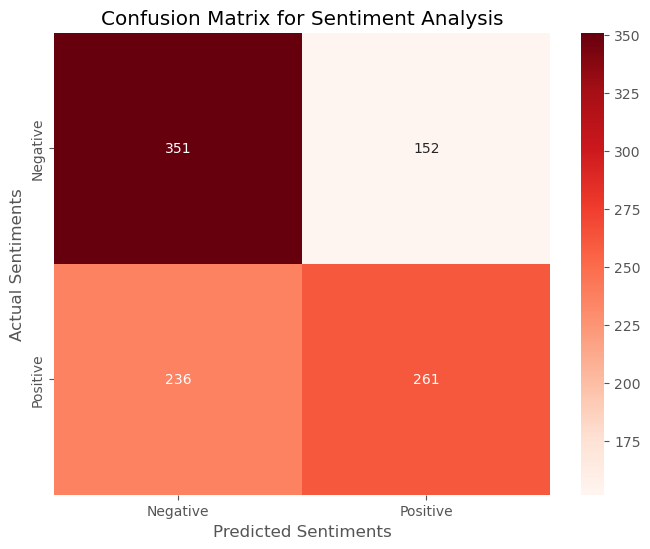

In [38]:
# confusion matrix
conf_matrix = confusion_matrix(df["target_map"], df["sentiment"], labels=["Negative", "Positive"])
conf_labels = ["Negative", "Positive"]

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=conf_labels, yticklabels=conf_labels)
plt.xlabel("Predicted Sentiments")
plt.ylabel("Actual Sentiments")
plt.title("Confusion Matrix for Sentiment Analysis")
plt.show()

Overall, the accuracy of the model's analysis is 61.2%.
Based on the results we can conclude that the model is moderately accurate with
negative and positive sentiment classification. This can be explained by the 
fact that vocabulary that people use on social media and on twitter specifically
can be very different from the vocabulary used in the data that was used to 
train the model.

## Task №4

For finding all persons and organizations in positive tweets, we will use spaCy.

The spaCy model "en_core_web_sm" contains information about entities. 
By using it, we can find organizations or persons in tweets.

In [14]:
# filter df by only positive tweets
df_pos = df[df["sentiment"] == "Positive"]
df_pos

,target,text,tokens,sentiment,f_sentiment,f_confidence
0,4,Going to pic quick join?,"[going, to, pic, quick, join]",Positive,NEGATIVE,0.972909
1,0,urg. i should be somewhere I really want to b...,"[urg, i, should, be, somewhere, i, really, wan...",Positive,NEGATIVE,0.999929
2,4,Help me!!! Chanting NO CAKE NO CAKE!! LOL BD ...,"[help, me, chanting, no, cake, no, cake, lol, ...",Positive,POSITIVE,0.995531
3,0,"@AritheGenius Awww, we still love you though EB","[awww, we, still, love, you, though, eb]",Positive,POSITIVE,0.960257
6,0,"God its hot, cant even take the girls to the p...","[god, its, hot, ca, nt, even, take, the, girls...",Positive,NEGATIVE,0.957133
...,...,...,...,...,...,...
991,4,@Trace027 YVW I am good xx,"[yvw, i, am, good, xx]",Positive,POSITIVE,0.972112
992,0,@cfdj71 @Lollyjay Ah come on u already got an ...,"[ah, come, on, u, already, got, an, oh, am, al...",Positive,POSITIVE,0.939209
993,4,"238, 265, 213 / 279, 285, 277 / 271, 291, 280 ...","[new, wold, records]",Positive,POSITIVE,0.999215
994,4,Wow. I'm @work already. I'm 45 minutes early! ...,"[wow, i, already, i, minutes, early, lol, well...",Positive,POSITIVE,0.902167


In [15]:
def entities_in_texts(df):
    # list to store new rows
    expanded_rows = []

    # iterate over each row in the df
    for _, row in df.iterrows():
        text = row['text']  # extract text from the current row
        doc = nlp(text)     # process the text with the NLP model

        # find entities in the processed text
        for ent in doc.ents:
            # check if the entity is an organization or a person
            if ent.label_ == "ORG" or ent.label_ == "PERSON":
                # create a new row for each entity found
                expanded_rows.append({
                    'target': row['target'],  
                    'text': text,             
                    'tokens': row['tokens'],  
                    'sentiment': row['sentiment'],  
                    'entity': ent.text,       
                    'entity_type': ent.label_ 
                })

    # create a new df from the expanded rows
    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df  # return the new DataFrame

# call the function and create a new df with entities
df_entities = entities_in_texts(df_pos)
df_entities  # display the new df

,target,text,tokens,sentiment,entity,entity_type
0,0,urg. i should be somewhere I really want to b...,"[urg, i, should, be, somewhere, i, really, wan...",Positive,urg,PERSON
1,4,Help me!!! Chanting NO CAKE NO CAKE!! LOL BD ...,"[help, me, chanting, no, cake, no, cake, lol, ...",Positive,BD,ORG
2,0,"@AritheGenius Awww, we still love you though EB","[awww, we, still, love, you, though, eb]",Positive,@AritheGenius,PERSON
3,0,"@AritheGenius Awww, we still love you though EB","[awww, we, still, love, you, though, eb]",Positive,EB,PERSON
4,0,@mitchelmusso so cool! if only i could call! m...,"[so, cool, if, only, i, could, call, my, phone...",Positive,@mitchelmusso,PERSON
...,...,...,...,...,...,...
163,0,@lowrobb not only banned but people who love t...,"[not, only, banned, but, people, who, love, to...",Positive,@lowrobb,PERSON
164,4,@zaydia i was tweeting from the parking lot in...,"[i, was, tweeting, from, the, parking, lot, in...",Positive,@zaydia,PERSON
165,4,"238, 265, 213 / 279, 285, 277 / 271, 291, 280 ...","[new, wold, records]",Positive,wold,ORG
166,4,Wow. I'm @work already. I'm 45 minutes early! ...,"[wow, i, already, i, minutes, early, lol, well...",Positive,Pax,ORG


**Conclusion:**
1. The spaCy model "en_core_web_trf" could find entities in tweets, but it doesn't do it really good.
2. The reason why this model is not good for working with tweets could be that tweets are written in a specific language, while this model is not designed for specific textsts.
3. Therefore, for working with tweets, it is better to use specialized models or train such models yourself.


## Task №5

For find most friquent organizations and persons in positive
tweets lets  use pandas and counter.


In [16]:
# most friquent organizations
df_entities[df_entities['entity_type'] == 'ORG'] \
['entity'].value_counts().head(5)

entity
Twitter           2
BD                1
Wimbledon         1
UP                1
@Jonasbrothers    1
Name: count, dtype: int64

In [18]:
# most friquent persons
df_entities[df_entities['entity_type'] == 'PERSON'] \
['entity'].value_counts().head(5)

entity
@stephenfry       2
urg               1
savage garden     1
@fraseredwards    1
Gary              1
Name: count, dtype: int64

**Conclusion:**
1. The most friquent ORG is Twitter
2. The most friquent Person is @stephenfry  
3. Some entities could be recognized with mistakes (e.g., 'urg', 'shell', etc.) because it is not specific to Twitter language.

## Task №6

## Task №7